In [1]:
#Libraries
import pandas as pd
import pandas as pd
from surprise import Reader, Dataset, KNNBasic, accuracy, PredictionImpossible
from collections import defaultdict
from surprise.model_selection import KFold
from random import shuffle
import matplotlib.pyplot as plt

#Importing the data
data = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/upsampled_df_smote.csv')
data.head()

,userId,wine,rate
0,5ccd8030-047b-432c-a630-d784ab415756,Valpolicella Ripasso,3
1,df904a46-c461-4233-9d44-6ac11a8bbddc,Astrale,3
2,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Bricco Riva Bianca,3
3,bc79b0e3-064d-4240-86de-e86499f577e8,3/11 Syrah and blend #4,3
4,5ccd8030-047b-432c-a630-d784ab415756,Valpolicella Ripasso Classico Superiore Pojega,4


In [2]:
#metrics
metrics_df = pd.DataFrame(
    columns=['Index','Model','Metric','Optimizer','User_based',
             'RMSE','MAE','MSE', 'Precision', 'Recall', 'Accuracy'])
print(metrics_df)

Empty DataFrame
Columns: [Index, Model, Metric, Optimizer, User_based, RMSE, MAE, MSE, Precision, Recall, Accuracy]
Index: []


In [3]:
class Knn (KNNBasic):
    def __init__(self, sim_options={}, bsl_options={}):
        KNNBasic.__init__(self, sim_options=sim_options, bsl_options=bsl_options)
    
    def create_reader(self, data):
        reader = Reader(rating_scale=(1, 5))
        self.data = Dataset.load_from_df(data[['userId', 'wine', 'rate']], reader)

    def fit (self):
        '''Divide the data into train and test manually '''
        #Frist shuffle the data
        raw_ratings = self.data.raw_ratings
        shuffle(raw_ratings)
        
        #75% of the data for training and the rest for testing
        threshold = int(.80 * len(raw_ratings))
        train_raw_ratings = raw_ratings[:threshold]
        test_raw_ratings = raw_ratings[threshold:]
        
        #Update the data object with train raw ratings
        self.data.raw_ratings = train_raw_ratings
        
        #Define a cross-validation iterator
        kf = KFold(n_splits=5, shuffle= True, random_state=42)
        
        train_rmse_list = []
        test_rmse_list = []
        
        for trainset_fold, testset_fold in kf.split(self.data):
            #Train and test algorithm.
            KNNBasic.fit(self, trainset_fold)
            train_prediction = KNNBasic.test(self, trainset_fold.build_testset())
            prediction = KNNBasic.test(self, testset_fold)

            #Error on training
            train_rmse = accuracy.rmse(train_prediction)
            train_rmse_list.append(train_rmse)

            #Error on testing
            test_rmse = accuracy.rmse(prediction)
            test_rmse_list.append(test_rmse)

        avg_train_rmse = sum(train_rmse_list) / len(train_rmse_list)
        avg_test_rmse = sum(test_rmse_list) / len(test_rmse_list)
        print("###############################################")
        print("The Results are: \n")
        print(f"Average RMSE on Training Set: {avg_train_rmse}")
        print(f"Average RMSE on Test Set: {avg_test_rmse}")

        #Predict ratings for all pairs (u, i) that are NOT in the training set.
        #Update the data object with test raw ratings
        self.data.raw_ratings = test_raw_ratings
        #adapting the Testset to be compatible with Surprise
        testset = self.data.construct_testset(self.data.raw_ratings)
        #Predicting the ratings for testset
        predictions = KNNBasic.test(self, testset)
        #RMSE
        test_rmse = accuracy.rmse(predictions)
        print(f"RMSE on Test Set on UNSEEN DATA is RMSE, : {test_rmse}")

        self.sim = self.compute_similarities()
        self.bu, self.bi = self.compute_baselines()
        return predictions
    
    def get_user_name(self, uid):
        """Return the name of a user from their id.
        Args:
            uid(int): The raw id of the user.
        Returns:
            The name of the user.
        """
        return self.trainset.to_raw_uid(uid)
    
    def get_item_name(self, iid):
        """Return the name of an item from their id.
        Args:
            iid(int): The raw id of the item.
        Returns:
            The name of the item.
        """
        return self.trainset.to_raw_iid(iid)
    
    def get_neighbors_uid(self, user_id, k=10):
        neighbor_ids = self.get_neighbors(user_id, k=10)
        neighbor_names = [self.get_user_name(uid) for uid in neighbor_ids]
        return neighbor_names
    def get_neighbors_iid(self, item_id, k=10):
        neighbor_ids = self.get_neighbors(item_id, k=10)
        neighbor_names = [self.get_item_name(iid) for iid in neighbor_ids]
        return neighbor_names
        
    def get_top_n_for_user(self, predictions,user_id, n=10):
        """Return the top-N recommendation for a user from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            n(int): The number of recommendation to output for each user. Default
                is 10.

        Returns:
        A dict where keys are user (raw) ids and values are lists of tuples:
            [(raw item id, rating estimation), ...] of size n.
        """

        # First map the predictions to each user.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if uid == user_id:
                top_n[uid].append((iid, est))

        # Then sort the predictions for the user and retrieve the k highest ones.
        user_ratings = top_n[user_id]
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[user_id] = user_ratings[:n]

        return top_n[user_id]
    
    def get_top_n_users_for_item(self, predictions, item_id, n=10):
        """Return the top-N users for a specific item from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            item_id: The id of the item for which to get the top-N users.
            n(int): The number of users to output for the item. Default is 10.

        Returns:
        A list of tuples:
            [(raw user id, rating estimation), ...] of size n.
        """

        # First map the predictions to each item.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if iid == item_id:
                top_n[iid].append((uid, est))

        # Then sort the predictions for the item and retrieve the k highest ones.
        item_ratings = top_n[item_id]
        item_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[item_id] = item_ratings[:n]

        return top_n[item_id]

    def estimated(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")
        
        #Compute similarities between u and v, where v describes all other
        #users that have also rated item i.
        neighbors = [(v, self.sim[u, v]) for (v, r) in self.trainset.ir[i]]
        # Sort these neighbors by similarity
        neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)

        print("The 5 nearest neighbors of user", str(u), "are:")
        for v, sim_uv in neighbors[:5]:
            print(f"user {v} with sim {sim_uv:1.15f}")

        # ... Aaaaand return the baseline estimate anyway ;)
        bsl = self.trainset.global_mean + self.bu[u] + self.bi[i]
        return print(f"And the baseline estimate is: {bsl}")
    
    def get_Iu(self, uid):
        """Return the number of items rated by given user
        args:
          uid: the id of the user
        returns:
          the number of items rated by the user
        """
        try:
            return len(self.trainset.ur[self.trainset.to_inner_uid(uid)])
        except ValueError:  # user was not part of the trainset
            return 0

    def get_Ui(self, iid):
        """Return the number of users that have rated given item
        args:
          iid: the raw id of the item
        returns:
          the number of users that have rated the item.
        """
        try:
            return len(self.trainset.ir[self.trainset.to_inner_iid(iid)])
        except ValueError:
            return 0

    def inspect_predictions(self, predictions):
        print(f"uid means the user id and iid means the wine id\n")
        print(f"rui means the actual rating and est means the estimated rating\n")
        print(f"err means the error between the actual and the estimated rating\n")
        print(f"Iu means the number of items rated by given user\n")
        print(f"Ui means the number of users that have rated given item\n")
        # Create a dataframe with the predictions
        df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
        df_pred['Iu'] = df_pred.uid.apply(self.get_Iu)
        df_pred['Ui'] = df_pred.iid.apply(self.get_Ui)
        df_pred['err'] = abs(df_pred.est - df_pred.rui)
        return df_pred
    
    def get_accuracy(self, predictions, k=10, threshold=3.5):
        #Compute RMSE
        rmse = accuracy.rmse(predictions, verbose=True)
        #Compute MAE
        mae = accuracy.mae(predictions, verbose=True)
        # Compute MSE
        mse = accuracy.mse(predictions, verbose=True)

        #Compute precision and recall
        precisions, recalls = self.precision_recall_at_k(predictions, k=k, threshold=threshold)

        #Precision and recall can then be averaged over all users
        precision = sum(prec for prec in precisions.values()) / len(precisions)
        recall = sum(rec for rec in recalls.values()) / len(recalls)
        print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}')

        #Count correct predictions
        correct = 0
        for uid, iid, true_r, est, _ in predictions:
            if round(est) == round(true_r):
                correct += 1

        #Compute accuracy
        accuracy_percentage = correct / len(predictions)
        accuracy_percentage = accuracy_percentage * 100
        print(f"the acc is {accuracy_percentage:.2f}")

        #Return a dictionary with the metrics
        return {'RMSE': rmse, 'MAE': mae, 'MSE': mse, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy_percentage}
        
    @staticmethod 
    def precision_recall_at_k(predictions, k=10, threshold=3.5):
        """Return precision and recall at k metrics for each user"""
        # First map the predictions to each user.
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():
            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            # Number of recommended items in top k
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

            # Number of relevant and recommended items in top k
            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in user_ratings[:k]
            )

            # Precision@K: Proportion of recommended items that are relevant
            # When n_rec_k is 0, Precision is undefined. We here set it to 0.
            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

            # Recall@K: Proportion of relevant items that are recommended
            # When n_rel is 0, Recall is undefined. We here set it to 0.
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        return precisions, recalls

## Knn SGD

* knn cosine, user based

In [4]:
knn = Knn(
    #THE k was missing 
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn.create_reader(data)
predictions = knn.fit()
#acc
metrics = knn.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 1
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7938
RMSE: 1.3854
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7327
RMSE: 1.4124
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7951
RMSE: 1.3789
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8211
RMSE: 1.4280
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8080
RMSE: 1.3839
###############################################
The Results are: 

Average RMSE on Training Set: 0.7901455828420911
Average RMSE on Test Set: 1.3977323339693957
RMSE: 1.3152
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.315158679395672
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.3152
MAE:  1.0651
MSE: 1.7296
Precision: 0.06
Recall: 0.04
the acc is 34.55


/tmp/ipykernel_17240/161991997.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn cosine, item based

In [5]:
knn2 = Knn(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn2.create_reader(data)
predictions = knn2.fit()
#acc
metrics = knn2.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 2
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0340
RMSE: 1.3140
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0073
RMSE: 1.3642
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0051
RMSE: 1.4057
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0509
RMSE: 1.3497
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0069
RMSE: 1.3469
###############################################
The Results are: 

Average RMSE on Training Set: 1.0208361112802338
Average RMSE on Test Set: 1.356125115616857
RMSE: 1.4084
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.4083713349651654
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.4084
MAE:  1.1753
MSE: 1.9835
Precision: 0.03
Recall: 0.02
the acc is 25.65


/tmp/ipykernel_17240/3130600781.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17240/3130600781.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn mean squared difference, user based

In [6]:
knn3 = Knn(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn3.create_reader(data)
predictions = knn3.fit()
#acc
metrics = knn3.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 3
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2296
RMSE: 1.3481
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2262
RMSE: 1.3681
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2346
RMSE: 1.3080
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2116
RMSE: 1.3841
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2471
RMSE: 1.3550
###############################################
The Results are: 

Average RMSE on Training Set: 0.2298147877907431
Average RMSE on Test Set: 1.3526421452433182
RMSE: 1.3636
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.3636119055552138
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.3636
MAE:  1.1297
MSE: 1.8594
Precision: 0.05
Recall: 0.03
the acc is 26.70


/tmp/ipykernel_17240/3369594395.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17240/3369594395.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn mean squared diference, item based

In [7]:
knn4 = Knn(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn4.create_reader(data)
predictions = knn4.fit()
#acc
metrics = knn4.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 4
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4370
RMSE: 1.3612
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4001
RMSE: 1.4029
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4103
RMSE: 1.3218
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4143
RMSE: 1.3460
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4221
RMSE: 1.2369
###############################################
The Results are: 

Average RMSE on Training Set: 0.4167443571697831
Average RMSE on Test Set: 1.333744553176032
RMSE: 1.3424
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.3424417666937383
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.3424
MAE:  1.0900
MSE: 1.8021
Precision: 0.07
Recall: 0.05
the acc is 29.32


/tmp/ipykernel_17240/1900242280.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17240/1900242280.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn pearson, user based

In [8]:
knn5 = Knn(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn5.create_reader(data)
predictions = knn5.fit()
#acc
metrics = knn5.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 5
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1176
RMSE: 1.2803
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1536
RMSE: 1.3274
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1474
RMSE: 1.3859
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1478
RMSE: 1.3008
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1175
RMSE: 1.3871
###############################################
The Results are: 

Average RMSE on Training Set: 0.13674891279488788
Average RMSE on Test Set: 1.3362933459160797
RMSE: 1.3447
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.3446933205576441
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.3447
MAE:  1.1275
MSE: 1.8082
Precision: 0.02
Recall: 0.02
the acc is 24.61


/tmp/ipykernel_17240/3339916766.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17240/3339916766.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn pearson, item based

In [9]:
knn6 = Knn(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn6.create_reader(data)
predictions = knn6.fit()
#acc
metrics = knn6.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 6
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1048
RMSE: 1.3505
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1820
RMSE: 1.3204
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1773
RMSE: 1.4618
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0843
RMSE: 1.3205
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1603
RMSE: 1.3336
###############################################
The Results are: 

Average RMSE on Training Set: 0.1417190603732834
Average RMSE on Test Set: 1.3573490558988106
RMSE: 1.3366
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.3365637345576562
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.3366
MAE:  1.0784
MSE: 1.7864
Precision: 0.05
Recall: 0.03
the acc is 30.37


/tmp/ipykernel_17240/3614094042.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17240/3614094042.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn (shrunk) pearson correlation coefficient, user based

In [10]:
knn7 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn7.create_reader(data)
predictions = knn7.fit()
#acc
metrics = knn7.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 7
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1510
RMSE: 1.3078
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1559
RMSE: 1.3215
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1065
RMSE: 1.4088
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0943
RMSE: 1.3800
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1525
RMSE: 1.2941
###############################################
The Results are: 

Average RMSE on Training Set: 0.13202945322594956
Average RMSE on Test Set: 1.3424346786935382
RMSE: 1.3757
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.375726959371184
Computing the pearson_baseline similarity matrix.

/tmp/ipykernel_17240/3960392171.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17240/3960392171.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn (shrunk) pearson correlation coefficient, item based

In [11]:
knn8 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn8.create_reader(data)
predictions = knn8.fit()
#acc
metrics = knn8.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 8
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0905
RMSE: 1.3443
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1422
RMSE: 1.4372
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1618
RMSE: 1.3112
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0816
RMSE: 1.3233
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1538
RMSE: 1.3517
###############################################
The Results are: 

Average RMSE on Training Set: 0.12598058398567483
Average RMSE on Test Set: 1.3535452219015949
RMSE: 1.2985
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.2985449205829016
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_17240/3933834523.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17240/3933834523.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


Done computing similarity matrix.
RMSE: 1.2985
MAE:  1.0436
MSE: 1.6862
Precision: 0.04
Recall: 0.03
the acc is 32.98


## Knn Alternating Least Squares (ALS)

* knn cosine, user based

In [12]:
knn9 = Knn(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn9.create_reader(data)
predictions = knn9.fit()
#acc
metrics = knn9.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 9
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7073
RMSE: 1.4117
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7836
RMSE: 1.3735
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7772
RMSE: 1.3528
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6942
RMSE: 1.4005
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7799
RMSE: 1.3230
###############################################
The Results are: 

Average RMSE on Training Set: 0.7484566786307971
Average RMSE on Test Set: 1.3723017262658845
RMSE: 1.3752
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.3751971737562443
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.3752
MAE:  1.1313
MSE: 1.8912
Precision: 0.04
Recall: 0.03
the acc is 27.23


/tmp/ipykernel_17240/3513140556.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17240/3513140556.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn cosine, item based

In [13]:
knn10 = Knn(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn10.create_reader(data)
predictions = knn10.fit()
#acc
metrics = knn10.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 10
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0404
RMSE: 1.3871
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0221
RMSE: 1.4432
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0438
RMSE: 1.3100
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0188
RMSE: 1.3308
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0150
RMSE: 1.3016
###############################################
The Results are: 

Average RMSE on Training Set: 1.0280312286424695
Average RMSE on Test Set: 1.3545480900586728
RMSE: 1.3970
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.3970158085303457
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.3970
MAE:  1.2008
MSE: 1.9517
Precision: 0.01
Recall: 0.01
the acc is 21.99


/tmp/ipykernel_17240/857205367.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17240/857205367.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn mean squared difference, user based

In [14]:
knn11 = Knn(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn11.create_reader(data)
predictions = knn11.fit()
#acc
metrics = knn11.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 11
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2230
RMSE: 1.4808
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2538
RMSE: 1.4106
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2493
RMSE: 1.3381
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2597
RMSE: 1.3689
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2329
RMSE: 1.3626
###############################################
The Results are: 

Average RMSE on Training Set: 0.2437228478987512
Average RMSE on Test Set: 1.3922110868744362
RMSE: 1.2883
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.2882694415392313
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.2883
MAE:  1.0381
MSE: 1.6596
Precision: 0.04
Recall: 0.03
the acc is 31.41


/tmp/ipykernel_17240/1804258722.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17240/1804258722.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn mean squared difference, item based

In [15]:
knn12 = Knn(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn12.create_reader(data)
predictions = knn12.fit()
#acc
metrics = knn12.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 12
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4083
RMSE: 1.3235
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4332
RMSE: 1.3816
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4227
RMSE: 1.4899
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4278
RMSE: 1.3161
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4160
RMSE: 1.3518
###############################################
The Results are: 

Average RMSE on Training Set: 0.42158013324317445
Average RMSE on Test Set: 1.3725949419390335
RMSE: 1.2943
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.2942999566060056
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.2943
MAE:  1.0640
MSE: 1.6752
Precision: 0.05
Recall: 0.03
the acc is 29.32


/tmp/ipykernel_17240/262444695.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17240/262444695.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn pearson correlation coefficient, user based

In [16]:
knn13 = Knn(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn13.create_reader(data)
predictions = knn13.fit()
#acc
metrics = knn13.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 13
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1413
RMSE: 1.2961
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1447
RMSE: 1.3851
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1045
RMSE: 1.3383
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1186
RMSE: 1.3961
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0835
RMSE: 1.2802
###############################################
The Results are: 

Average RMSE on Training Set: 0.11853389719960834
Average RMSE on Test Set: 1.3391651436907202
RMSE: 1.3580
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.3580411120352487
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.3580
MAE:  1.0922
MSE: 1.8443
Precision: 0.02
Recall: 0.01
the acc is 33.51


/tmp/ipykernel_17240/1092855449.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17240/1092855449.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn pearson correlation coefficient, item based

In [17]:
knn14 = Knn(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn14.create_reader(data)
predictions = knn14.fit()
#acc
metrics = knn14.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 14
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1026
RMSE: 1.2913
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1334
RMSE: 1.2981
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1045
RMSE: 1.3734
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0573
RMSE: 1.3019
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1302
RMSE: 1.4005
###############################################
The Results are: 

Average RMSE on Training Set: 0.10559523635390844
Average RMSE on Test Set: 1.3330269046287397
RMSE: 1.3780
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.378028479268782
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.3780
MAE:  1.1350
MSE: 1.8990
Precision: 0.04
Recall: 0.02
the acc is 28.27


/tmp/ipykernel_17240/3580080987.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17240/3580080987.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn (shrunk) pearson correlation coefficient, user based

In [18]:
knn15 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn15.create_reader(data)
predictions = knn15.fit()
#acc
metrics = knn15.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 15
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0952
RMSE: 1.3559
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0972
RMSE: 1.2397
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0677
RMSE: 1.3616
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0758
RMSE: 1.3561
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0885
RMSE: 1.3675
###############################################
The Results are: 

Average RMSE on Training Set: 0.08488509279015818
Average RMSE on Test Set: 1.3361675778760518
RMSE: 1.2988
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.2988350438851686
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_17240/3271800746.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17240/3271800746.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn (shrunk) pearson correlation coefficient, item based

In [19]:
knn16 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn16.create_reader(data)
predictions = knn16.fit()
#acc
metrics = knn16.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 16
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0927
RMSE: 1.3637
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1508
RMSE: 1.3874
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1073
RMSE: 1.4179
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1567
RMSE: 1.3690
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1374
RMSE: 1.2523
###############################################
The Results are: 

Average RMSE on Training Set: 0.1289825790105745
Average RMSE on Test Set: 1.3580768787638404
RMSE: 1.3291
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.3291471503465437
Computing the pearson_baseline similarity matrix.

/tmp/ipykernel_17240/3154310150.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17240/3154310150.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [20]:
metrics_df.sort_values(by='RMSE', ascending=True, inplace=True)
metrics_df

,Index,Model,Metric,Optimizer,User_based,RMSE,MAE,MSE,Precision,Recall,Accuracy
10,11,KnnBasic,MSD,ALS,True,1.288269,1.038122,1.659638,0.044304,0.029938,31.413613
11,12,KnnBasic,MSD,ALS,False,1.294300,1.064045,1.675212,0.051282,0.029915,29.319372
7,8,KnnBasic,(shrunk) pearson corr coeff,SGD,False,1.298545,1.043563,1.686219,0.035294,0.025210,32.984293
14,15,KnnBasic,(shrunk) pearson corr coeff,ALS,True,1.298835,1.085226,1.686972,0.049383,0.029835,27.748691
0,1,KnnBasic,Cosine,SGD,True,1.315159,1.065134,1.729642,0.064103,0.043498,34.554974
15,16,KnnBasic,(shrunk) pearson corr coeff,ALS,False,1.329147,1.094338,1.766632,0.022222,0.007778,28.795812
5,6,KnnBasic,pearson corr coeff,SGD,False,1.336564,1.078388,1.786403,0.046512,0.030127,30.366492
3,4,KnnBasic,MSD,SGD,False,1.342442,1.090038,1.802150,0.068750,0.045208,29.319372
4,5,KnnBasic,pearson corr coeff,SGD,True,1.344693,1.127474,1.808200,0.020000,0.016667,24.607330
12,13,KnnBasic,pearson corr coeff,ALS,True,1.358041,1.092181,1.844276,0.022989,0.009579,33.507853


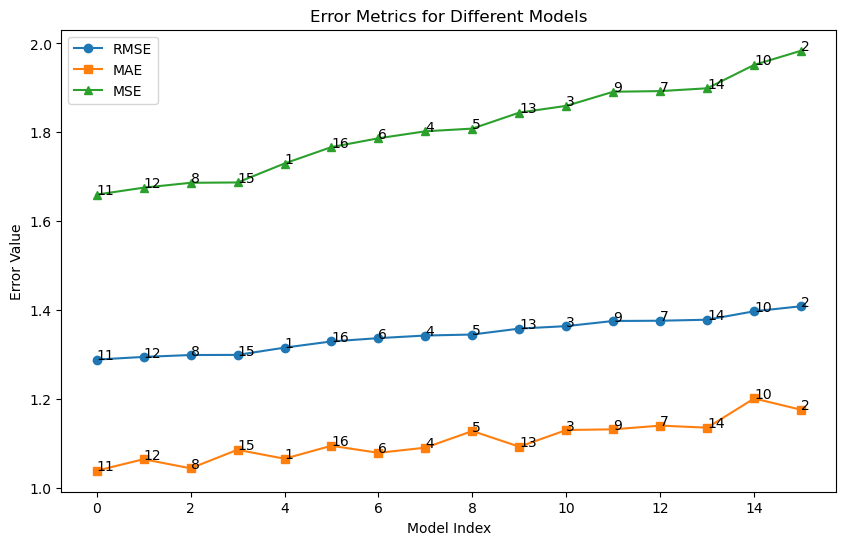

In [21]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MAE'], marker='s', linestyle='-', label='MAE')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MSE'], marker='^', linestyle='-', label='MSE')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MAE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MSE'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

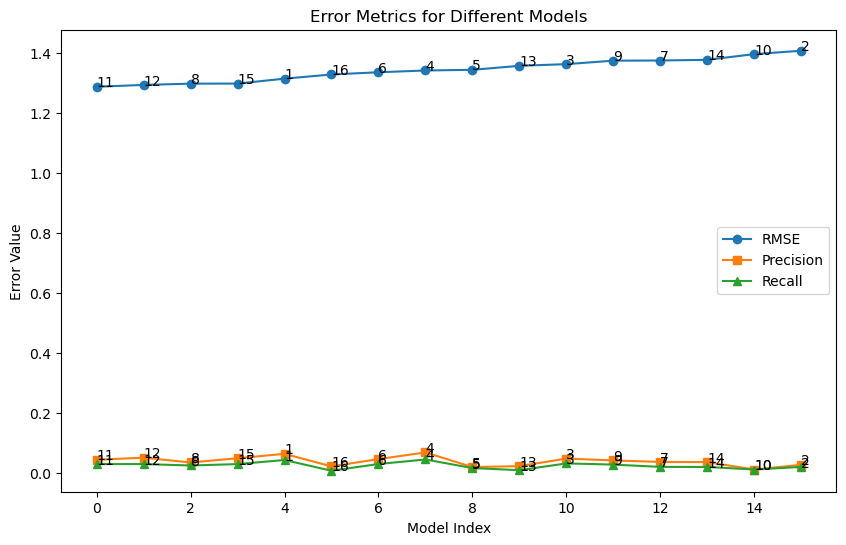

In [22]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Precision'], marker='s', linestyle='-', label='Precision')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Recall'], marker='^', linestyle='-', label='Recall')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Precision'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Recall'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

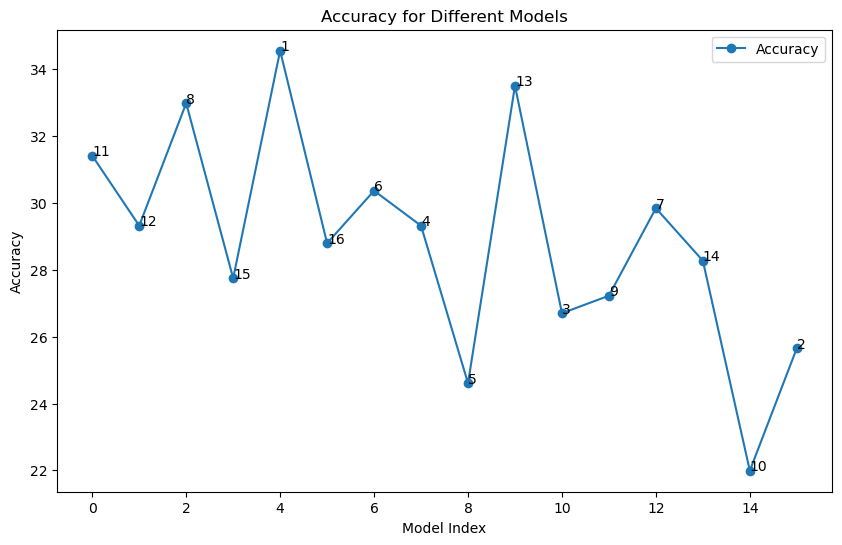

In [23]:
plt.figure(figsize=(10, 6))

#Plot Accuracy with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Accuracy'], marker='o', linestyle='-', label='Accuracy')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Accuracy'].iloc[i]))

#Setting title and labels
plt.title('Accuracy for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Accuracy')

#legend
plt.legend()
plt.show()

## Estimates

In [24]:
#recommends items for a given user from predictions

# user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
# top_n = knn.get_top_n_for_user(predictions, user_id)
# print(user_id, [iid for (iid, _) in top_n])
######### better print
user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
top_n = knn.get_top_n_for_user(predictions, user_id)
print(f"Top items for the user '{user_id}' are:")
for i, (iid, _) in enumerate(top_n, 1):
    print(f"{i}. Item ID: {iid}")

Top items for the user '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7' are:
1. Item ID: Le Relais de Patache d'Aux
2. Item ID: Mendoza Malbec selected vines
3. Item ID: Valle Central Merlot
4. Item ID: Lodi California
5. Item ID: Les Pierrelles Crozes-Hermitage


In [25]:
# recommneds users for a given item from predictions

# item_id = 'Chardonnay'
# top_n = knn.get_top_n_users_for_item(predictions, item_id)
# print(item_id, [uid for (uid, _) in top_n])
########## better print
item_id = 'Chardonnay'
top_n = knn.get_top_n_users_for_item(predictions, item_id)
print(f"Top users for the item '{item_id}' are:")
for i, (uid, _) in enumerate(top_n, 1):
    print(f"{i}. User ID: {uid}")

Top users for the item 'Chardonnay' are:
1. User ID: 918cd9b7-8057-4106-8f7f-9e9e3a423fb1


In [26]:
#get the KNN for a user from the model
knn.get_neighbors_uid(user_id=5)

['4ed273f7-1816-4f36-88c7-789125f011c7',
 '70c67292-57ce-4012-a939-5e6ddcb499f8',
 '457b85f5-7b46-4f52-85b9-59acb549b9a2',
 '71d38b96-326c-4d01-afc4-b12c947a5c6b',
 'cabb87a0-6498-438a-beb7-676f72bddd09',
 '5c865810-7a40-4eb4-93c3-970c4d6ce4da',
 '3b1f7bc8-6a23-47e5-97df-043bd1b97f12',
 '4e9cb62e-a165-484b-ad78-cb215523cdd5',
 '4e4e45dd-0473-45c3-be2f-45b33d075f88',
 'd838a526-4b0a-4fad-b54f-90b6ca321fca']

In [27]:
#get the KNN for an item from the model
knn.get_neighbors_iid(item_id=20)

['Chablis Saint Martin',
 'Silvaner',
 "The Society's Exhibition Shiraz",
 "The Old Man's Blend",
 'Brunello di Montalcino ',
 'Pinot Noir',
 '3／17 Temata Awatea',
 'Pas Dosé',
 'Fidelis',
 'Zinfandel']

In [28]:
knn.estimated(13,20)
print('\n#####\n')
print("Note: If the baseline is {} then the value is a default value, Otherwise not".format(knn.trainset.global_mean))

The 5 nearest neighbors of user 13 are:
user 15 with sim 0.000000000000000
user 25 with sim 0.000000000000000
And the baseline estimate is: 1.9850199617302278

#####

Note: If the baseline is 2.855737704918033 then the value is a default value, Otherwise not


In [29]:
df_pred = knn.inspect_predictions(predictions)
best_pred = df_pred.sort_values(by='err')[:10]
worst_pred = df_pred.sort_values(by='err')[-10:]
df_pred.head(10)

uid means the user id and iid means the wine id

rui means the actual rating and est means the estimated rating

err means the error between the actual and the estimated rating

Iu means the number of items rated by given user

Ui means the number of users that have rated given item



,uid,iid,rui,est,details,Iu,Ui,err
0,dcd16582-14d2-4e00-a024-9b5886d29b29,Cordero con piel de lobo,4.0,2.909836,"{'was_impossible': True, 'reason': 'User and/o...",5,1,1.090164
1,c2dfb861-cdad-4fb2-9460-fc794c7f6cad,Zinfandel,1.0,2.909836,"{'was_impossible': True, 'reason': 'Not enough...",2,1,1.909836
2,b0fbc6bd-4b1e-48cd-92f3-f49b7a505941,Taurasi Vigna Cinque Querce,5.0,2.909836,"{'was_impossible': True, 'reason': 'Not enough...",3,2,2.090164
3,99654a70-c3bb-46f4-8697-b9345482e48d,Dark (Red Blend),4.0,2.909836,"{'was_impossible': True, 'reason': 'User and/o...",2,0,1.090164
4,776b5af7-bb8a-484a-bddb-dadf5dab4621,Muscat de Beaumes-de-Venise,5.0,2.909836,"{'was_impossible': True, 'reason': 'User and/o...",3,3,2.090164
5,bc79b0e3-064d-4240-86de-e86499f577e8,Les Grands Blancs,2.0,2.909836,"{'was_impossible': True, 'reason': 'User and/o...",30,2,0.909836
6,976ec198-048f-405c-b6e6-b17ee1db1139,Nebbiolo d alba superiore,4.0,2.909836,"{'was_impossible': True, 'reason': 'User and/o...",3,2,1.090164
7,bc79b0e3-064d-4240-86de-e86499f577e8,3／18 大陸白 6 Lepus Pinot Bianco,3.0,2.909836,"{'was_impossible': True, 'reason': 'User and/o...",30,1,0.090164
8,595d2e23-9c80-4c9b-aae0-2a6cb4eeae2b,Moscata D'Asti Casaniere,1.0,2.909836,"{'was_impossible': True, 'reason': 'Not enough...",1,9,1.909836
9,4313b57d-e3f7-495e-bcfd-ff5c1bf15fcc,P’tit Piaf Rouge,5.0,2.909836,"{'was_impossible': True, 'reason': 'User and/o...",7,0,2.090164


* best predictions

In [30]:
best_pred

,uid,iid,rui,est,details,Iu,Ui,err
60,5ccd8030-047b-432c-a630-d784ab415756,Maikammer Kirchenstück,3.0,3.000000,"{'actual_k': 3, 'was_impossible': False}",52,1,0.000000
58,20e0b694-84a5-4f11-9191-598f924c2947,Morellino di Scansano 2021,1.0,1.000000,"{'actual_k': 3, 'was_impossible': False}",4,10,0.000000
89,76b71bb0-6cc9-4168-8a45-bbafc1e9a256,Brachetto Piemonte,4.0,4.000000,"{'actual_k': 1, 'was_impossible': False}",10,3,0.000000
175,4313b57d-e3f7-495e-bcfd-ff5c1bf15fcc,Morellino di Scansano DOCG terre di talamo,1.0,1.000000,"{'actual_k': 3, 'was_impossible': False}",7,8,0.000000
105,f7fb310d-87f1-441a-94ab-f526f66b9ec1,Montefalco Rosso,1.0,1.000000,"{'actual_k': 6, 'was_impossible': False}",6,5,0.000000
110,ba14097a-c2ac-4d16-a8b9-a237bdc73592,Nebbiolo d'Alba,1.0,1.000000,"{'actual_k': 1, 'was_impossible': False}",3,5,0.000000
153,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Chianti classico,3.0,2.993471,"{'actual_k': 15, 'was_impossible': False}",72,1,0.006529
72,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Lagrein,3.0,2.993471,"{'actual_k': 15, 'was_impossible': False}",72,3,0.006529
119,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Pojega,3.0,2.993471,"{'actual_k': 15, 'was_impossible': False}",72,0,0.006529
161,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Bricco Riva Bianca,3.0,2.993471,"{'actual_k': 15, 'was_impossible': False}",72,2,0.006529


* worst predictions

In [31]:
worst_pred

,uid,iid,rui,est,details,Iu,Ui,err
129,defee34b-7775-4889-b703-92b730d85e70,meeker,5.0,2.909836,"{'was_impossible': True, 'reason': 'User and/o...",3,0,2.090164
127,bec96c0b-5b0b-4992-8756-e0d3b704afb5,Aspromonte,5.0,2.909836,"{'was_impossible': True, 'reason': 'User and/o...",6,0,2.090164
61,2a62eecd-b0cd-4395-9f8c-7c912a208be2,Casillero del diabolo merlot Chile,5.0,2.909836,"{'was_impossible': True, 'reason': 'User and/o...",19,1,2.090164
62,a3b393ad-38d5-4c5a-b814-5fec18a1fa9d,Opera Viva,5.0,2.909836,"{'was_impossible': True, 'reason': 'Not enough...",3,2,2.090164
64,bc79b0e3-064d-4240-86de-e86499f577e8,3／4 大亂鬥 2,5.0,2.909836,"{'was_impossible': True, 'reason': 'User and/o...",30,0,2.090164
66,918cd9b7-8057-4106-8f7f-9e9e3a423fb1,Chardonnay,5.0,2.909836,"{'was_impossible': True, 'reason': 'Not enough...",2,4,2.090164
68,ff89d8c1-48a3-49b5-af95-62d0ce9ecf55,Grey (Glacier) Cabernet Sauvignon,5.0,2.909836,"{'was_impossible': True, 'reason': 'User and/o...",1,1,2.090164
78,31434f5c-846c-4e06-93d6-193efdeb250c,Strada di Guia 109 Extra Dry,5.0,2.909836,"{'was_impossible': True, 'reason': 'User and/o...",0,0,2.090164
17,22c5c1cb-88fd-4870-a911-846516978ed4,Malbec (High Mountain Vines),5.0,2.909836,"{'was_impossible': True, 'reason': 'Not enough...",2,2,2.090164
95,bc8f3005-c2c6-4277-9fd7-340248f4e7ec,Bollicina,5.0,2.909836,"{'was_impossible': True, 'reason': 'Not enough...",7,3,2.090164
